<a href="https://colab.research.google.com/github/dspselorm/Recommendation-System-Analysis/blob/main/Recommendation_System_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RECOMMENDATION SYSTEM ANALYSIS AND MODELING PROJECT**

### **GOAL**

Personalize item suggestions for users based on their interaction history (clicks, add to cart, and transactions)

### **Libraries**

In [15]:
import pandas as pd
import numpy as np
import re
import glob
import os
import duckdb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go

### **Import Google Drive Content**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Merge the two "Item_Properties.csv" files**

In [ ]:
# Define the path to your data folder
data_folder = '/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/Item_properties_data'
items_properties_data = glob.glob(os.path.join(data_folder, "*.csv"))

# Read and combine all CSV files in 2020 folder
df_item = []

for file in items_properties_data:
    try:
        df = pd.read_csv(file)
        df_item.append(df)
        print(f"Loaded: {os.path.basename(file)} with {len(df)} rows")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Concatenate all DataFrames into one
combined_df = pd.concat(df_item, ignore_index=True)
print(f"Successfully merged {len(df_item)} files into a single DataFrame with {len(combined_df)} rows.")

# Save the combined data
output_path = os.path.join('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/', "item_properties_merged.csv")
combined_df.to_csv(output_path, index=False)
print(f"Merged file saved to: {output_path}")

Loaded: item_properties_part1.1.csv with 10999999 rows
Loaded: item_properties_part2.csv with 5638803 rows
Successfully merged 2 files into a single DataFrame with 16638802 rows.
Merged file saved to: /content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/item_properties_merged.csv


### **Upload Datasets**

**1. Item_Properties Dataset**

In [4]:
chunksize = 100000
chunks = []

for chunk in pd.read_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/item_properties_merged.csv', chunksize=chunksize):

    chunks.append(chunk)

df_item_properties = pd.concat(chunks, ignore_index=True)
print("File loaded successfully with shape:", df_item_properties.shape)

File loaded successfully with shape: (16638802, 4)


**2. Category_Tree Dataset**

In [5]:
df_category_tree = pd.read_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/category_tree.csv')
print("File loaded successfully with shape:", df_category_tree.shape)

File loaded successfully with shape: (1669, 2)


**3. Events Dataset**

In [6]:
df_events = pd.read_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/events.csv')
print("File loaded successfully with shape:", df_events.shape)

File loaded successfully with shape: (2756101, 5)


In [7]:
df_item_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638802 entries, 0 to 16638801
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 507.8+ MB


In [8]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [9]:
df_category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


**Filter out rows where property is 'categoryid' or 'available'**

In [10]:
# Filter out rows where property is 'categoryid' or 'available'
df_item_properties_filtered = df_item_properties[
    df_item_properties['property'].isin(['categoryid', 'available'])
]

# Save to CSV
df_item_properties_filtered.to_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/item_properties_filtered.csv', index=False)

print(f"Filtered dataset saved with {len(df_item_properties_filtered)} rows.")

Filtered dataset saved with 1881100 rows.


In [11]:
df_item_properties_filtered

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
5,1436065200000,285026,available,0
15,1437274800000,186518,available,0
79,1433646000000,423682,available,0
82,1434250800000,316253,available,1
...,...,...,...,...
16638759,1442113200000,409366,available,1
16638761,1431831600000,376865,available,1
16638763,1431831600000,286888,categoryid,1277
16638786,1438484400000,264025,available,1


## **Begin Data Preparation**

In [12]:
df_category_tree['parentid'] = df_category_tree['parentid'].fillna(0).astype(int)
df_category_tree['parentid'] = df_category_tree['parentid'].fillna(0).astype(str)
df_category_tree['categoryid'] = df_category_tree['categoryid'].astype(str)

**Correct Date Columns**

In [13]:
df_events['timestamp'] = pd.to_datetime(df_events['timestamp'], unit='ms', errors='coerce')
df_item_properties_filtered['timestamp'] = pd.to_datetime(df_item_properties_filtered['timestamp'], unit='ms', errors='coerce')

/tmp/ipython-input-1873278124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_item_properties_filtered['timestamp'] = pd.to_datetime(df_item_properties_filtered['timestamp'], unit='ms', errors='coerce')


**Correct itemid column datatypes**

In [14]:
df_events['itemid'] = pd.to_numeric(df_events['itemid'], errors='coerce')
df_item_properties['itemid'] = pd.to_numeric(df_item_properties['itemid'], errors='coerce')

**Correct Transaction ID Datatype**

In [15]:
# Change Transaction ID to int, Null Values remain null
df_events['transactionid'] = df_events['transactionid'].apply(lambda x: '' if pd.isna(x) else str(int(x)))

In [16]:
text_only_props = df_item_properties.loc[
    ~df_item_properties['property'].str.fullmatch(r'\d+(\.\d+)?')
]['property'].unique()
text_only_props

array(['categoryid', 'available'], dtype=object)

**Merge Event dataset with Filtered Item Properties Dataset**

In [17]:
# Register in DuckDB
duckdb.register('events', df_events)
duckdb.register('item_props_filtered', df_item_properties_filtered)

# Merge & pivot categoryid and available
df_merged = duckdb.query("""
WITH props AS (
    SELECT
        itemid,
        timestamp,
        MAX(CASE WHEN property = 'categoryid' THEN value END) AS categoryid,
        MAX(CASE WHEN property = 'available' THEN value END) AS available
    FROM df_item_properties_filtered
    GROUP BY itemid, timestamp
),
latest_props AS (
    SELECT *
    FROM (
        SELECT
            e.*,
            p.categoryid,
            p.available,
            ROW_NUMBER() OVER (
                PARTITION BY e.itemid, e.timestamp
                ORDER BY p.timestamp DESC
            ) AS rn
        FROM events e
        LEFT JOIN props p
        ON e.itemid = p.itemid
        AND p.timestamp <= e.timestamp
    )
    WHERE rn = 1
)
SELECT * EXCLUDE (rn)
FROM latest_props
""").to_df()

# Save merged file
df_merged.to_csv("/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/Cleaned/merged_events_properties.csv", index=False)

print("Merge complete. Shape:", df_merged.shape)
df_merged

Merge complete. Shape: (2755607, 7)


,timestamp,visitorid,event,itemid,transactionid,categoryid,available
0,2015-08-27 17:09:02.814,890305,view,6,,None,0
1,2015-06-27 03:25:15.690,633965,view,15,,None,1
2,2015-07-21 00:02:59.529,1090955,view,15,,None,0
3,2015-06-08 02:36:08.535,456617,view,25,,1509,1
4,2015-07-13 00:33:48.394,291866,view,25,,1509,1
...,...,...,...,...,...,...,...
2755602,2015-06-28 17:43:12.779,1324382,view,253452,,None,1
2755603,2015-07-01 02:09:37.153,248815,view,253452,,None,1
2755604,2015-07-06 03:01:15.872,31174,view,253474,,624,1
2755605,2015-09-07 18:37:15.600,994820,view,253500,,None,0


In [18]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755607 entries, 0 to 2755606
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  object        
 5   categoryid     object        
 6   available      object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 147.2+ MB


In [19]:
df_final = pd.merge(df_merged, df_category_tree, on='categoryid', how='left')

In [20]:
df_final

,timestamp,visitorid,event,itemid,transactionid,categoryid,available,parentid
0,2015-08-27 17:09:02.814,890305,view,6,,None,0,NaN
1,2015-06-27 03:25:15.690,633965,view,15,,None,1,NaN
2,2015-07-21 00:02:59.529,1090955,view,15,,None,0,NaN
3,2015-06-08 02:36:08.535,456617,view,25,,1509,1,620
4,2015-07-13 00:33:48.394,291866,view,25,,1509,1,620
...,...,...,...,...,...,...,...,...
2755602,2015-06-28 17:43:12.779,1324382,view,253452,,None,1,NaN
2755603,2015-07-01 02:09:37.153,248815,view,253452,,None,1,NaN
2755604,2015-07-06 03:01:15.872,31174,view,253474,,624,1,871
2755605,2015-09-07 18:37:15.600,994820,view,253500,,None,0,NaN


In [26]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755607 entries, 0 to 2755606
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  object        
 5   categoryid     object        
 6   available      object        
 7   parentid       object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 168.2+ MB


In [62]:
df_final.isnull().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,0
categoryid,1851592
available,1082839
parentid,1851592


In [63]:
# Save merged file
df_final.to_csv("/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/Cleaned/full_cleaned_dataset_events_properties_category.csv", index=False)

## **Load Fully Cleaned Dataset to begin Visualizations and Analysis**

In [2]:
df_cleaned_final = pd.read_csv('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Dataset/Cleaned/full_cleaned_dataset_events_properties_category.csv')

In [4]:
df_cleaned_final['timestamp'] = pd.to_datetime(df_cleaned_final['timestamp'], errors='coerce')
df_cleaned_final['visitorid'] = df_cleaned_final['visitorid'].astype(str).astype('object')
df_cleaned_final['itemid'] = df_cleaned_final['itemid'].astype(str).astype('object')
df_cleaned_final['transactionid'] = df_cleaned_final['transactionid'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan).astype('object')
df_cleaned_final['categoryid'] = df_cleaned_final['categoryid'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan).astype('object')
df_cleaned_final['available'] = df_cleaned_final['available'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan).astype('object')
df_cleaned_final['parentid'] = df_cleaned_final['parentid'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan).astype('object')

In [5]:
df_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755607 entries, 0 to 2755606
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      object        
 2   event          object        
 3   itemid         object        
 4   transactionid  object        
 5   categoryid     object        
 6   available      object        
 7   parentid       object        
dtypes: datetime64[ns](1), object(7)
memory usage: 168.2+ MB


In [6]:
df_cleaned_final

,timestamp,visitorid,event,itemid,transactionid,categoryid,available,parentid
0,2015-08-27 17:09:02.814,890305,view,6,NaN,NaN,0,NaN
1,2015-06-27 03:25:15.690,633965,view,15,NaN,NaN,1,NaN
2,2015-07-21 00:02:59.529,1090955,view,15,NaN,NaN,0,NaN
3,2015-06-08 02:36:08.535,456617,view,25,NaN,1509,1,620
4,2015-07-13 00:33:48.394,291866,view,25,NaN,1509,1,620
...,...,...,...,...,...,...,...,...
2755602,2015-06-28 17:43:12.779,1324382,view,253452,NaN,NaN,1,NaN
2755603,2015-07-01 02:09:37.153,248815,view,253452,NaN,NaN,1,NaN
2755604,2015-07-06 03:01:15.872,31174,view,253474,NaN,624,1,871
2755605,2015-09-07 18:37:15.600,994820,view,253500,NaN,NaN,0,NaN


In [7]:
df_cleaned_final.isnull().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733150
categoryid,1851592
available,1082839
parentid,1851592


## **VISUALIZATIONS AND ANALYSIS**

### **1. What common item properties are most frequently associated with items users add to cart after viewing?**

/tmp/ipython-input-1198963151.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


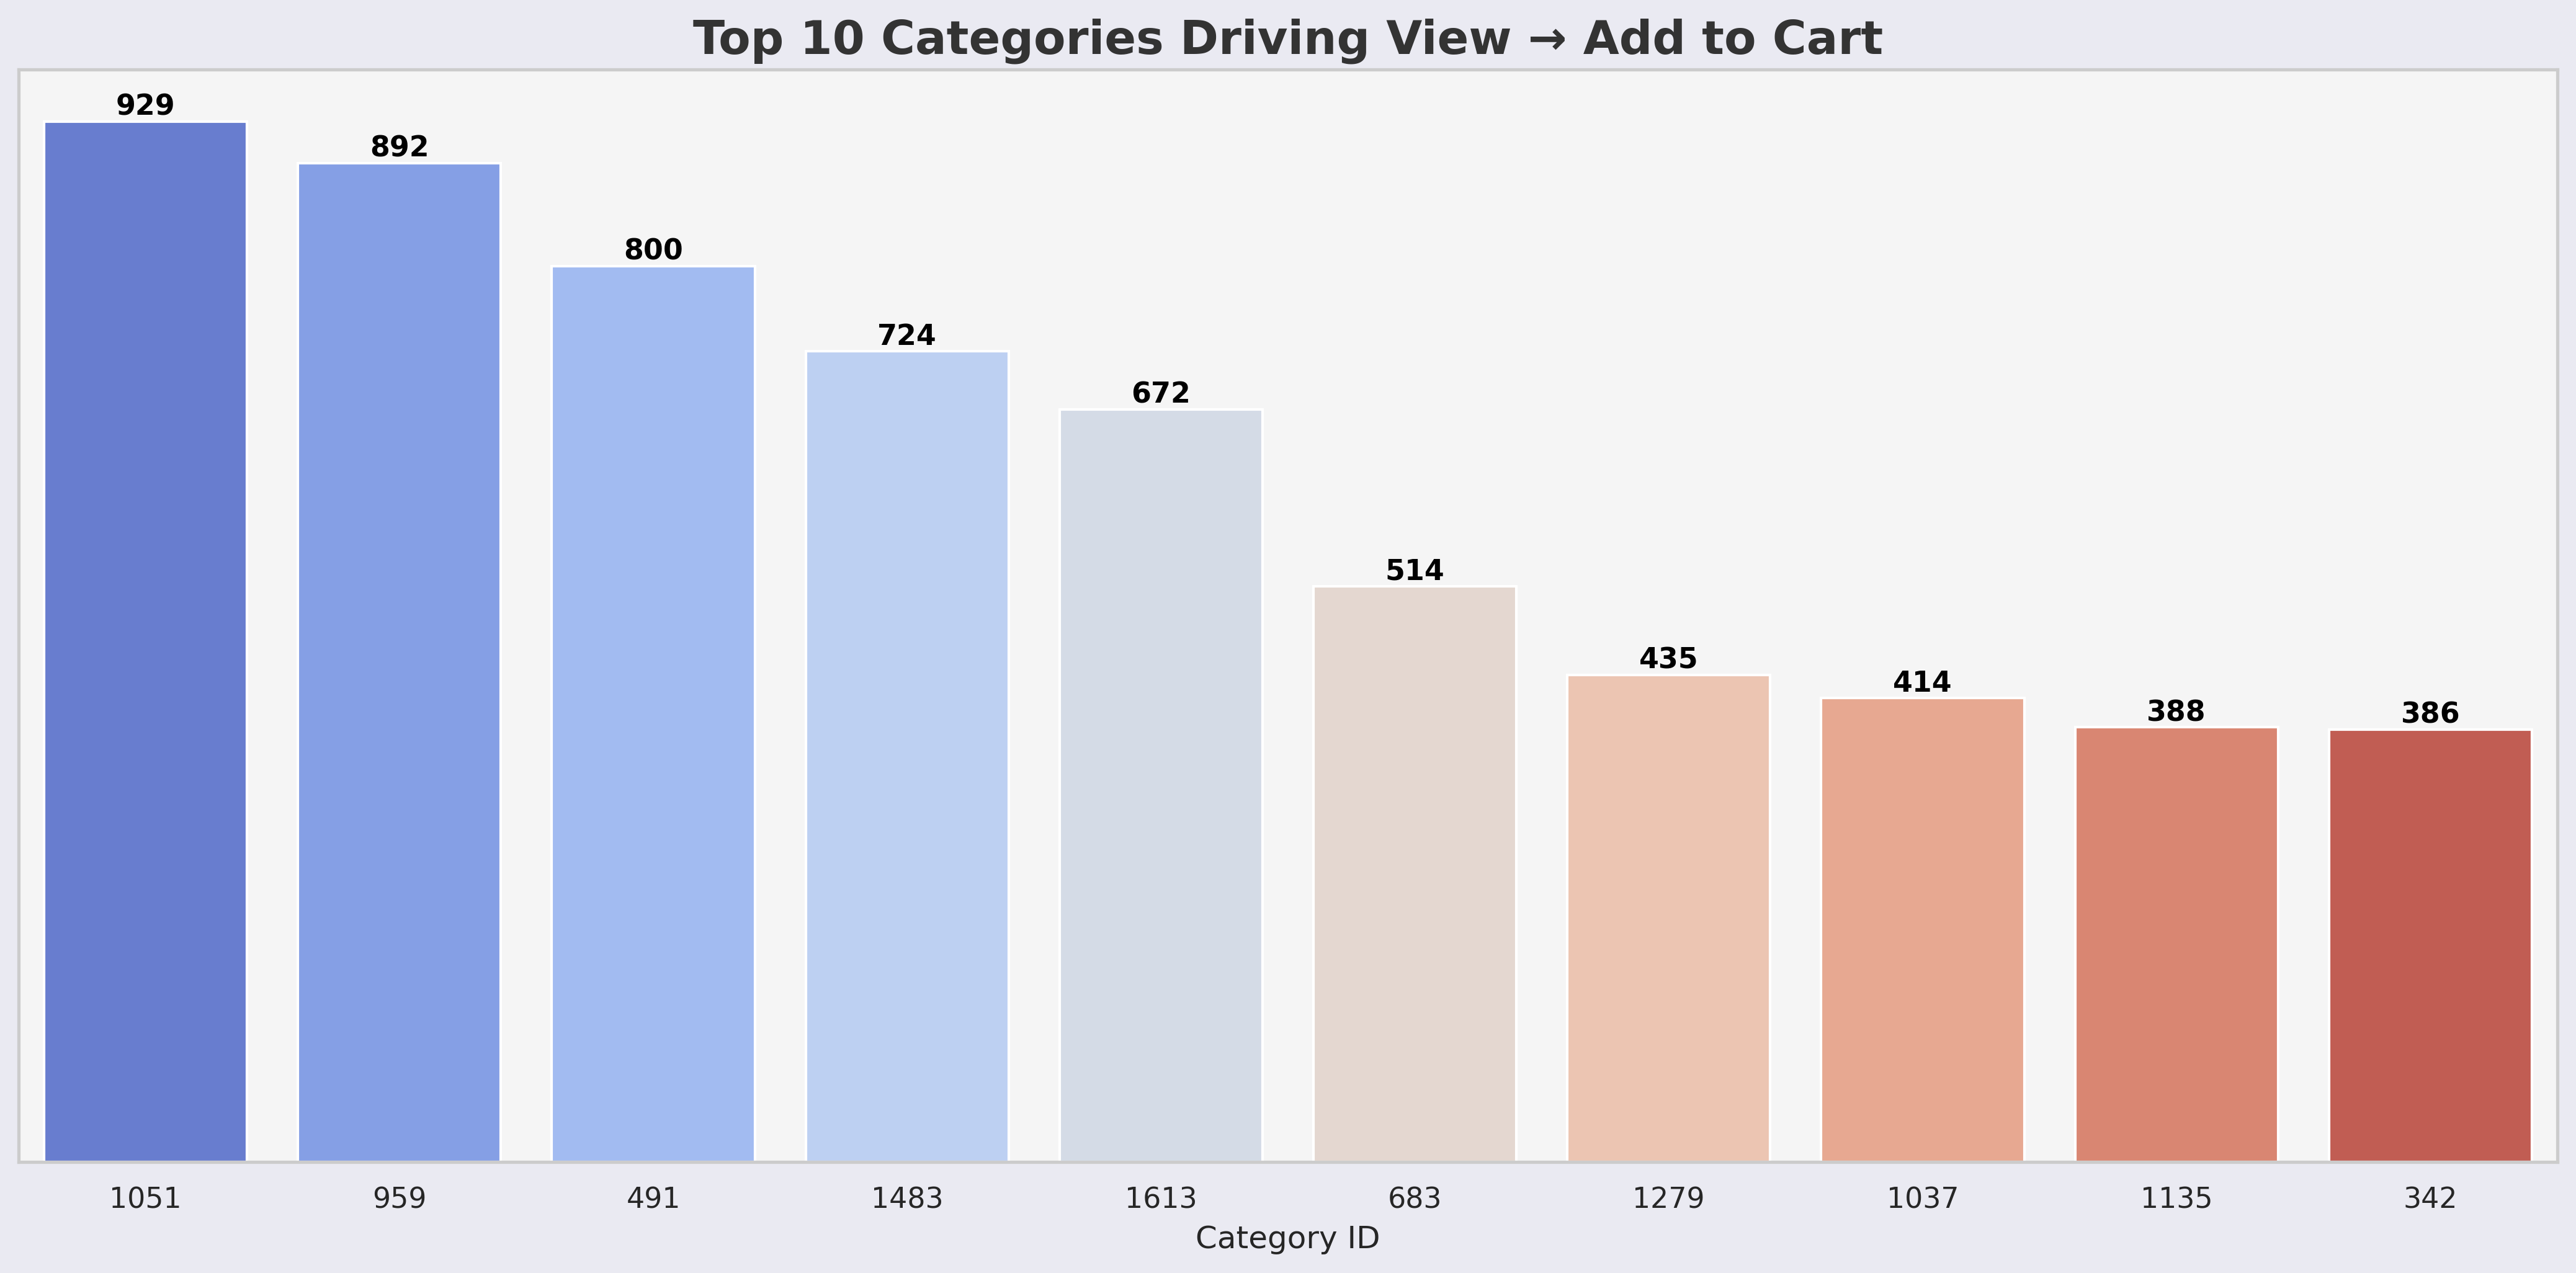

In [54]:
# Filter for 'view' and 'addtocart'
df_view_cart = df_cleaned_final[df_cleaned_final['event'].isin(['view', 'addtocart'])]

# Identify items where the same user viewed and then added to cart
converted_items = (
    df_view_cart.groupby(['visitorid', 'itemid'])['event']
    .apply(lambda x: set(x) >= {'view', 'addtocart'})
    .reset_index()
)
converted_items = converted_items[converted_items['event'] == True][['visitorid', 'itemid']]

# Merge to get properties
converted_with_props = converted_items.merge(
    df_cleaned_final[['itemid', 'categoryid']],
    on='itemid',
    how='left'
).drop_duplicates()

# Count top categories
top_cats = converted_with_props['categoryid'].value_counts().head(10).reset_index()
top_cats.columns = ['categoryid', 'count']

# Sort for plotting
top_cats_sorted = top_cats.sort_values(by='count', ascending=False)

# Style and figure settings
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7), dpi=300)

# Bar plot
bar = sns.barplot(
    data=top_cats_sorted,
    x='categoryid',
    y='count',
    order=top_cats_sorted['categoryid'],
    palette='coolwarm'
)

# Add labels to bars
for p in bar.patches:
    bar.annotate(
        f'{int(p.get_height()):,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=11, color='black', weight='bold'
    )

# Titles & labels
plt.title('Top 10 Categories Driving View → Add to Cart', fontsize=18, weight='bold', color='#333')
plt.xlabel('Category ID')
plt.ylabel('')
plt.yticks([])

# Background colors
plt.gca().set_facecolor('#f5f5f5')  # plot area background
plt.gcf().set_facecolor('#eaeaf2')  # figure background

# Remove grid lines
plt.grid(False)

# Save & show
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/top10_view_to_cart_categories.png',
            dpi=300, bbox_inches='tight')
plt.show()


• Categories 1051, 959, and 491 dominate view-to-cart conversions, indicating strong product appeal.

• Mid- and low-ranking categories present growth potential with targeted optimization.

**Key Takeaway**

• High-performing categories can serve as benchmarks to uplift weaker segments through targeted strategies.

### **2. Can user viewing patterns be used to accurately predict the category or price range of the item they are likely to add to cart?**

In [8]:
print(df_cleaned_final['event'].unique())

['view' 'addtocart' 'transaction']


In [9]:
check_pairs = (
    df_cleaned_final.groupby(['visitorid', 'itemid'])['event']
    .apply(lambda x: set(x) >= {'view', 'addtocart'})
)
print("Number of view→addtocart pairs:", check_pairs.sum())

Number of view→addtocart pairs: 49492


In [10]:
check_trans = (
    df_cleaned_final.groupby(['visitorid', 'itemid'])['event']
    .apply(lambda x: set(x) >= {'view', 'transaction'})
)
print("Number of view→transaction pairs:", check_trans.sum())

Number of view→transaction pairs: 19048


In [25]:
# Filter relevant events
df_q3 = df_cleaned_final[df_cleaned_final['event'].isin(['view', 'addtocart', 'transaction'])].copy()
df_q3['timestamp'] = pd.to_datetime(df_q3['timestamp'])

# First event times per visitor-item
first_views = (
    df_q3[df_q3['event'] == 'view']
    .groupby(['visitorid', 'itemid'])['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'view_time'})
)

first_adds = (
    df_q3[df_q3['event'] == 'addtocart']
    .groupby(['visitorid', 'itemid'])['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'add_time'})
)

first_trans = (
    df_q3[df_q3['event'] == 'transaction']
    .groupby(['visitorid', 'itemid'])['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'trans_time'})
)

# Merge & calculate time differences (minutes)
merged_times = first_views.merge(first_adds, on=['visitorid', 'itemid'], how='left') \
                          .merge(first_trans, on=['visitorid', 'itemid'], how='left')

merged_times['time_to_cart'] = (merged_times['add_time'] - merged_times['view_time']).dt.total_seconds() / 60
merged_times['time_to_purchase'] = (merged_times['trans_time'] - merged_times['view_time']).dt.total_seconds() / 60

# Reshape for plotting
df_time_conv = pd.melt(
    merged_times,
    id_vars=['visitorid', 'itemid', 'view_time'],
    value_vars=['time_to_cart', 'time_to_purchase'],
    var_name='conversion_type',
    value_name='time_mins'
)

df_time_conv['conversion_type'] = df_time_conv['conversion_type'].replace({
    'time_to_cart': 'Add to Cart',
    'time_to_purchase': 'Purchase'
})

df_time_conv = df_time_conv.dropna()
df_time_conv = df_time_conv[df_time_conv['time_mins'] > 0]

# Weekly aggregation
df_time_conv['week'] = df_time_conv['view_time'].dt.to_period('W').apply(lambda r: r.start_time)

avg_time_weekly = (
    df_time_conv.groupby(['week', 'conversion_type'])['time_mins']
    .mean()
    .reset_index()
)
avg_time_weekly = avg_time_weekly.sort_values('week')

# One label per month
annotations = []
for ctype in avg_time_weekly['conversion_type'].unique():
    sub_df = avg_time_weekly[avg_time_weekly['conversion_type'] == ctype]
    sub_df['month'] = sub_df['week'].dt.to_period('M')
    first_weeks = sub_df.groupby('month').first().reset_index()

    for _, row in first_weeks.iterrows():
        annotations.append(dict(
            x=row['week'],
            y=row['time_mins'],
            text=f"{row['time_mins']:.0f}",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=-15,
            font=dict(color="black", size=10, family="Arial"),
            borderpad=0,
            bgcolor=None  # Transparent background
        ))

# Plotly chart
fig = go.Figure()

colors = {'Add to Cart': 'rgb(222,45,38)', 'Purchase': 'rgb(49,130,189)'}

for ctype in avg_time_weekly['conversion_type'].unique():
    sub_df = avg_time_weekly[avg_time_weekly['conversion_type'] == ctype]
    fig.add_trace(go.Scatter(
        x=sub_df['week'],
        y=sub_df['time_mins'],
        mode='lines+markers',
        name=ctype,
        line=dict(color=colors[ctype], width=2),
        marker=dict(size=6),
        hovertemplate='%{x}<br>%{y:.1f} min<extra>'+ctype+'</extra>'
    ))

# Add annotations
for ann in annotations:
    fig.add_annotation(ann)

# Layout styling
fig.update_layout(
    title="Average Time (mins) to Conversion Trend (Weekly)",
    xaxis_title="Week",
    yaxis_title="",
    yaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
    xaxis=dict(showgrid=False),
    template="plotly_white",
    plot_bgcolor="rgb(245,245,245)",
    paper_bgcolor="rgb(234,234,242)",
    font=dict(size=12),
    title_font=dict(size=20, color="#333"),
    hovermode="x unified",
)

# Save interactive HTML file
fig.write_html("/content/drive/MyDrive/Azubi_TMP/Recommendation_System_Project/Charts/time_to_conversion_trend_weekly_monthly_labels_clean.html")

# Show chart
fig.show()

/tmp/ipython-input-1715166449.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1715166449.py:68: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



•	Conversion times have steadily decreased across the period, with purchase delays dropping by over 80%.

•	Faster add-to-cart and purchase actions indicate growing platform efficiency and user decisiveness.

**Key Takeaway**

•	Users are making faster buying decisions, signaling improved engagement and possible gains in recommendation quality.
